In [9]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import sys
import json
import pprint
import matplotlib.pyplot as plt
from pathlib import Path
from math import sqrt

sys.path.append('../src')
from map import Map
from tools import barycenter, intersection_lines, distance

plt.rcParams['figure.figsize'] = [24, 16] # default is [6.0, 4.0], good value is [24, 16]
plt.rcParams['figure.dpi'] = 50 # default is 72, good value is 50

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Select data here
case = "brevent1"
casedir = Path("../data/") / case
with open(casedir / "info.json") as info:
    data = json.load(info)

summits = dict(list(zip("ABCDEFGHIJKLMNOPQRSTUVWXYZ", data['xy'])))
X = int(1.2 * max(s[0] for s in summits.values()))
Y = int(1.2 * max(s[1] for s in summits.values()))

#summits, X, Y = {"A": (200, 350), "B": (200,400), "C": (300, 400), "D": (350, 350)}, 500, 500
#summits, X, Y = {"A": (200, 400), "B": (230,300), "C": (270, 300), "D": (300, 400)}, 500, 500
#summits, X, Y = {"A": (200, 400), "B": (300,400)}, 500, 500
#summits, X, Y = {"A": (200, 400), "B": (300,400), "C": (350, 400)}, 500, 500
#summits, X, Y = {"A": (200, 400), "B": (300,300), "C": (350, 400)}, 500, 500
#summits, X, Y = {"A": (200, 400), "B": (300,490), "C": (350, 400)}, 500, 500
#summits, X, Y = {"A": (580699.7382771571, 4507400.68664104),
#                 "B": (580804.6916304922, 4505676.703058445),
#                 "C": (581609.581410255, 4507347.541329558),
#                 "D": (581254.816163511, 4505719.029647791),
#                 "E": (585631.31816891, 4511326.417595701),
#                 "F": (583353.5087769624, 4507365.711354206),
#                 "G": (583656.1661844028, 4506700.757532055)}, 100, 100
#for k in summits.keys():
#    summits[k] = (summits[k][0] / 10000, summits[k][1] / 100000)

In [11]:
summits

{'A': [553, 410],
 'B': [560, 221],
 'C': [488, 145],
 'D': [424, 22],
 'E': [298, 104],
 'F': [226, 174],
 'G': [153, 50]}

In [12]:
X, Y

(672, 492)

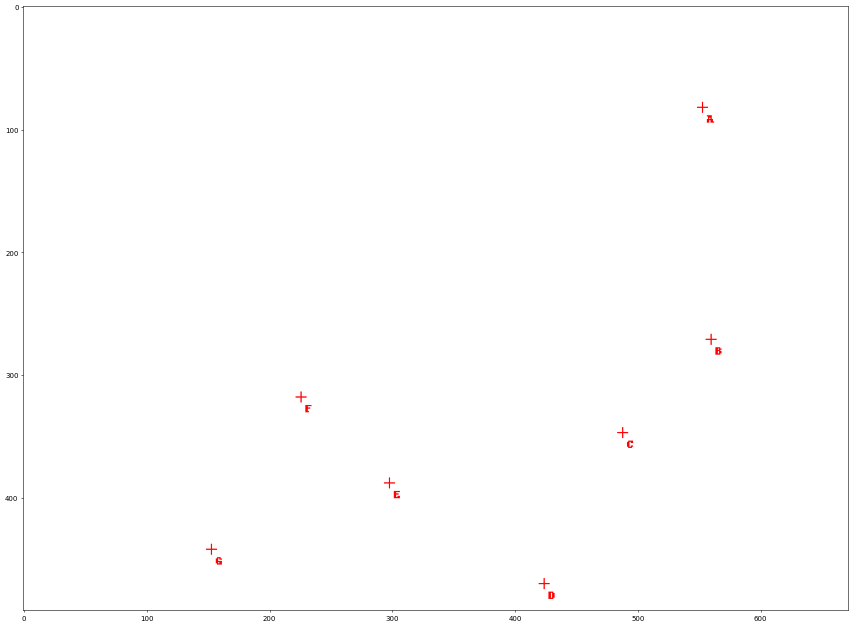

In [13]:
map = Map(dimensions=(X, Y), y_origin="bottom")
for k, s in summits.items():
    map.draw_point(s, name=k, color="red")
map.show()

In [14]:
def filter_points_on_the_right(points, vectors):
    """
    filter the points that are on the right of all the vectors.
    """
    # In a perfect worl, the threshold should simply be 0.
    # Numerical computation is not a perfect world.
    threshold = (sum(p[0] for p in points) + sum(p[1] for p in points)) / (2e10 * len(points))
    envelop = []
    for p in points:
        valid = True
        for v in vectors:
            vx, vy = v[1][0] - v[0][0], v[1][1] - v[0][1]
            px, py = p[0] - v[0][0], p[1] - v[0][1]
            cross = vx * py - vy * px
            if cross >= threshold:
                valid = False
                break
        if valid:
            envelop.append(p)
    return envelop

In [15]:
def find_all_intersections(vectors):
    """
    return all vectors intersections.
    """
    intersections = set()
    for i in range(0, len(vectors)):
        for j in range(i, len(vectors)):
            inter = intersection_lines(vectors[i][0], vectors[i][1], vectors[j][0], vectors[j][1])
            if inter is not None:
                intersections.add(inter)
    return list(intersections)

In [16]:
# Compute all summit vectors (photographer is on the right of those vectors)
vectors = []
lsummits = list(summits.values())
for i in range(0, len(lsummits)):
    for j in range(i + 1, len(lsummits)):
        vectors.append((lsummits[i], lsummits[j]))

# Find all points that are part on the edge of the area where the photographer can be.
# That is, the intersections of summit vectors that are on the right of all the summit vectors.
intersections = find_all_intersections(vectors)
envelop = filter_points_on_the_right(intersections + lsummits, vectors)
if len(envelop) == 0:
    raise RuntimeError(
        "Such a picture cannot be taken. "
        "Check the location and order of the points on the map and picture."
    )

# The envelop can be "open". Let's ensure it is closes by enclosing all of that in a square.
# First, let's define a square big enough to contain all of the above.
bary_summit = barycenter(summits.values())
mdist = 2* max([distance(bary_summit, p)
                for p 
                in envelop + list(summits.values())])
corners = [(bary_summit[0] - mdist, bary_summit[1] - mdist),
           (bary_summit[0] - mdist, bary_summit[1] + mdist),
           (bary_summit[0] + mdist, bary_summit[1] + mdist),
           (bary_summit[0] + mdist, bary_summit[1] - mdist)]
border_vectors = list(zip(corners, corners[1:] + corners[:1]))
 
# Let's do the same thing again with the newly added enclosing square.
close_vectors = vectors + border_vectors
close_intersections = find_all_intersections(close_vectors)
close_envelop = filter_points_on_the_right(close_intersections, close_vectors)
if len(close_envelop) == 0:
    raise RuntimeError(
        "Such a picture cannot be taken. "
        "Check the location and order of the points on the map and picture."
    )

# Sort points (trigo order) of the (convex) envelop
bary_envelop = barycenter(close_envelop)
pabove = [p for p in close_envelop if p[1] - bary_envelop[1] >= 0]
pbelow = [p for p in close_envelop if p[1] - bary_envelop[1] < 0]
pabovesorted = sorted(
    pabove,
    key=lambda p: -(p[0] - bary_envelop[0]) / sqrt((p[0] - bary_envelop[0]) ** 2 + (p[1] - bary_envelop[1]) ** 2),
)
pbelowsorted = sorted(
    pbelow,
    key=lambda p: (p[0] - bary_envelop[0]) / sqrt((p[0] - bary_envelop[0]) ** 2 + (p[1] - bary_envelop[1]) ** 2),
)
area = pabovesorted + pbelowsorted


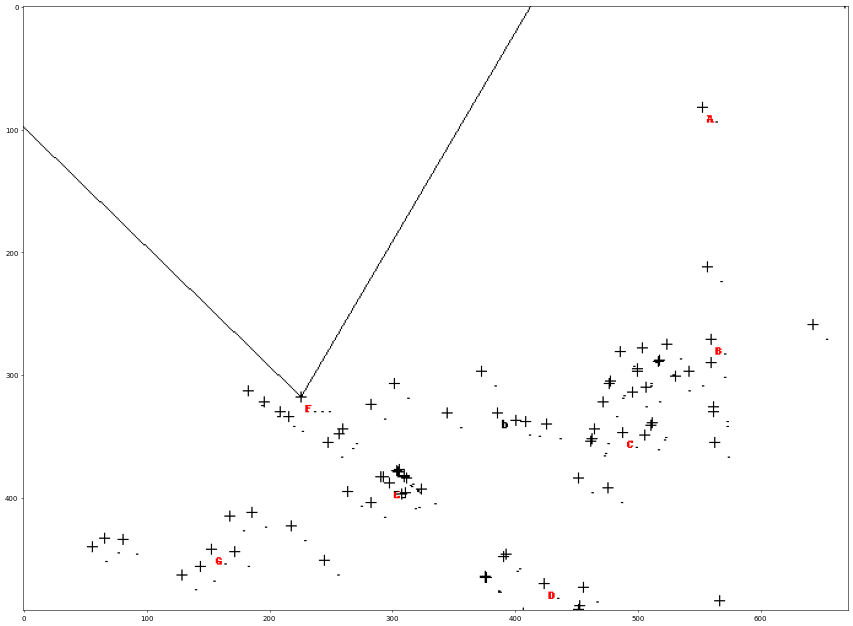

In [17]:
# Let's visualize a bit...
map.draw_point(bary_summit, name="b")
map.draw_point(bary_envelop, name="be")
for i in intersections:
    map.draw_point(i, name=" .")
for e in envelop:
    map.draw_point(e, name=" ..")
for e in close_envelop:
    map.draw_point(e, name=" ...")
for p, q in zip(area, area[1:] + area[:1]):
    map.draw_segment(p, q)
for p, q in border_vectors:
    map.draw_segment(p, q)

map.show()

In [18]:
def photographer_area(summits, xmin=None, xmax=None, ymin=None, ymax=None):
    """
    Return the envelop (a list of point) of the area where the photograph is located.
    summits: list of summits coordinates (x, y) in the order they appears on the picture (left to right).
    xmin, ... ymax: the enclosing area of the map.
    """

    # Compute all summit vectors (photographer is on the right of those vectors)
    summit_vectors = []
    for i in range(0, len(summits)):
        for j in range(i + 1, len(summits)):
            summit_vectors.append((summits[i], summits[j]))

    # An enclosing zone is needed to ensure a "closed" area
    if xmin is None:
        # Find all the corners of the area
        intersections = find_all_intersections(summit_vectors)
        envelop = filter_points_on_the_right(intersections + summits, summit_vectors)
        if len(envelop) == 0:
            raise RuntimeError(
                "Such a picture cannot be taken. "
                "Check the location and order of the points on the map and picture."
            )
        # Let's define a square centered on the barycentre and big enough to contain it all.
        bary_summit = barycenter(summits)
        mdist = 2 * max([distance(bary_summit, p) for p in envelop + summits])
        zone = [(bary_summit[0] - mdist, bary_summit[1] - mdist),
                (bary_summit[0] - mdist, bary_summit[1] + mdist),
                (bary_summit[0] + mdist, bary_summit[1] + mdist),
                (bary_summit[0] + mdist, bary_summit[1] - mdist)]
    else:
        zone = [(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)]
    
    # Find all the corners of the area
    zone_vectors = list(zip(zone, zone[1:] + zone[:1]))
    close_vectors = summit_vectors + zone_vectors
    close_intersections = find_all_intersections(close_vectors)
    close_envelop = filter_points_on_the_right(close_intersections, close_vectors)
    if len(close_envelop) == 0:
        raise RuntimeError(
            "Such a picture cannot be taken. "
            "Check the location and order of the points on the map and picture."
        )

    # Sort points (trigo order) of the (convex) envelop of the area
    bary_envelop = barycenter(close_envelop)
    pabovesorted = sorted(
        [p for p in close_envelop if p[1] - bary_envelop[1] >= 0],
        key=lambda p: -(p[0] - bary_envelop[0]) / sqrt((p[0] - bary_envelop[0]) ** 2 + (p[1] - bary_envelop[1]) ** 2),
    )
    pbelowsorted = sorted(
        [p for p in close_envelop if p[1] - bary_envelop[1] < 0],
        key=lambda p: (p[0] - bary_envelop[0]) / sqrt((p[0] - bary_envelop[0]) ** 2 + (p[1] - bary_envelop[1]) ** 2),
    )
    area = pabovesorted + pbelowsorted
    return area

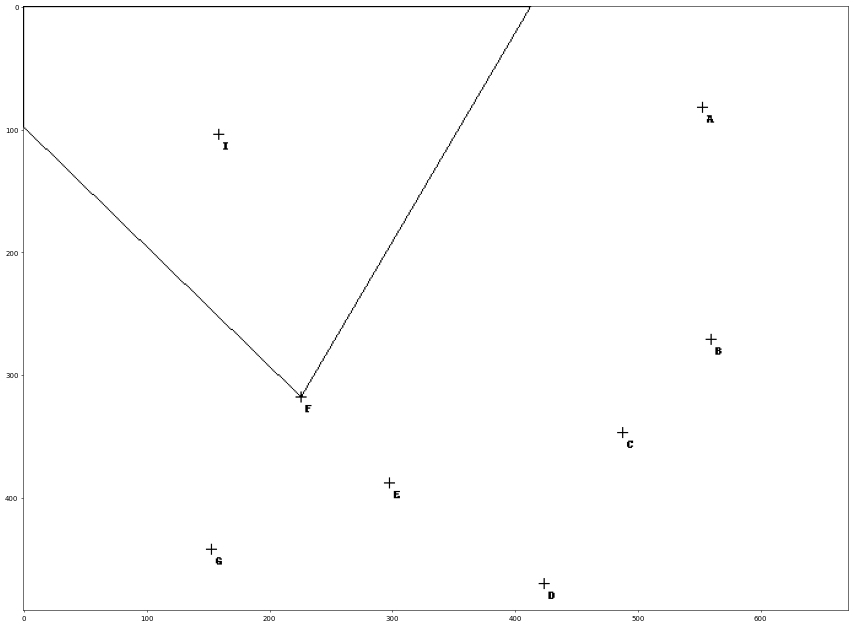

In [19]:
# Let's re-visualize a bit...

area = photographer_area(list(summits.values()), xmin=0, ymin=0, xmax=X, ymax=Y)

map = Map(dimensions=(X, Y), y_origin="bottom")
for k, s in summits.items():
    map.draw_point(s, name=k)
for p, q in zip(area, area[1:] + area[:1]):
    map.draw_segment(p, q)
map.draw_point(barycenter(area), name="I")
map.show()